# infinite TEBD

In [1]:

import pyuni10 as uni10
import numpy as np
import scipy.linalg as linalg
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Set up contraction graphs

In [2]:
def contract_theta(net, lamA, lamB, gamA, gamB, U):
    net.PutTensor("lamA", lamA)
    net.PutTensor("lamB", lamB)
    net.PutTensor("gamA", gamA)
    net.PutTensor("gamB", gamB)
    net.PutTensor("U", U)

    Tout = uni10.UniTensorR([])
    net.Launch(Tout)
    return Tout

def contract_lglgl(net, lamA, lamB, gamA, gamB):
    net.PutTensor("lamA", lamA)
    net.PutTensor("lamB", lamB)
    net.PutTensor("gamA", gamA)
    net.PutTensor("gamB", gamB)

    Tout = uni10.UniTensorR([])
    net.Launch(Tout)
    return Tout

def contract_lg(net, lam, gam):
    net.PutTensor("lam", lam)
    net.PutTensor("gam", gam)

    Tout = uni10.UniTensorR([])
    net.Launch(Tout)
    return Tout

def contract_gl(net, gam, lam):
    net.PutTensor("gam", gam)
    net.PutTensor("lam", lam)

    Tout = uni10.UniTensorR([])
    net.Launch(Tout)
    return Tout

## Network for $\Gamma$-$\Lambda$ contraction

## Network for $\Lambda$-$\Gamma$contraction

## Network for $\Lambda\Gamma\Lambda\Gamma\Lambda$ contraction

## Network for generating $\Theta$ 

## Time evolution operator and energy

In [3]:
def H_exp(Theta_net, LGLGL_net, lams, gams, H):
    ket = contract_theta(Theta_net, lams[0], lams[1], gams[0], gams[1], H)
    bra = contract_lglgl(LGLGL_net, lams[0], lams[1], gams[0], gams[1])
    return uni10.Contract(bra, ket).GetElem()[0]

def energy(Theta_net, LGLGL_net, lams, gams, H):
    ham_exp = H_exp(Theta_net, LGLGL_net, lams, gams, H)
    lglgl = contract_lglgl(LGLGL_net, lams[0], lams[1], gams[0], gams[1])

    E = ham_exp / (uni10.Contract(lglgl, lglgl).GetElem()[0]**2)
    return E


## Construct the Hamiltonian

We construct the Hamiltonian for the transverse Ising model: 

\begin{equation}
H=-\sum_{\langle ij\rangle} \sigma_i^z\sigma_j^z +h \sum_i \sigma_i^x
\end{equation}

In [5]:
Sz = uni10.UniTensorR([phys_bdi, phys_bdo], "Sz")
Sx = uni10.UniTensorR([phys_bdi, phys_bdo], "Sx")
Id = uni10.UniTensorR([phys_bdi, phys_bdo], "Id")

Sz.SetElem([1., 0., 0., -1.])
Sx.SetElem([0., 1., 1., 0.])
Id.SetElem([1., 0., 0., 1.])

H = -0.5*uni10.Otimes(Sz, Sz) + 0.25*uni10.Otimes(Id, Sx)
H.SetName("H")
print("Hamiltonian", H)

Hamiltonian 
***************** H *****************
REAL(0)

             ____________
            |            |
        0___|2          2|___2    
            |            |   
        1___|2          2|___3    
            |            |   
            |____________|

================BONDS===============
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
IN : (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2
OUT: (U1 = 0, P = 0, 0)|2, Dim = 2

===============BLOCKS===============
--- (U1 = 0, P = 0, 0): 
4 x 4 = 16 [ Actual Usage: 0 ], REAL

[ 
  -0.5000   0.2500   0.       0.    
   0.2500   0.5000   0.       0.    
   0.       0.       0.5000   0.2500
   0.       0.       0.2500  -0.5000
];
Total elemNum: 16





## Intialization

In [6]:

print("Pyuni10 1D iTEBD...")

print("Loading networks...")
LGLGL_net = uni10.Network("LGLGL.net")
Theta_net = uni10.Network("Theta.net")
LG_net = uni10.Network("LG.net")
GL_net = uni10.Network("GL.net")

print("Initializing 2-site Hamiltonian of 1D Ising model...")
phys_bdi = uni10.Bond(uni10.BD_IN, 2)
phys_bdo = uni10.Bond(uni10.BD_OUT, 2)



print("Initializing imaginary time evolution operator...")
dtau = 0.01
U_op = uni10.UniTensorR(H.bond())
U_elem = linalg.expm(-dtau*H.GetBlock())
U_op.PutBlock(U_elem)



Pyuni10 1D iTEBD...
Loading networks...
Initializing 2-site Hamiltonian of 1D Ising model...
Initializing imaginary time evolution operator...


## Initialize tensors and perform imaginary time evolution

In [7]:
print("Initializing Lambda and Gamma...")
virt_bdi = uni10.Bond(uni10.BD_IN, 1)
virt_bdo = uni10.Bond(uni10.BD_OUT, 1)

lams = [uni10.UniTensorR([virt_bdi, virt_bdo]), 
        uni10.UniTensorR([virt_bdi, virt_bdo])]
gams = [uni10.UniTensorR([virt_bdi, phys_bdi, virt_bdo]), 
        uni10.UniTensorR([virt_bdi, phys_bdi, virt_bdo])]
lams[0].SetElem([1.])
lams[1].SetElem([1.])
gams[0].SetElem([1., 0.])
gams[1].SetElem([0., 1.])

chi_max = 40
Es = []
print("Updating MPS... (with chi_max = {})".format(chi_max))
for i in range(1000):
    idx_a = i % 2
    idx_b = (i % 2) - 1
    Theta = contract_theta(Theta_net, lams[idx_a], lams[idx_b], gams[idx_a], gams[idx_b], U_op)

    U, S, Vt = linalg.svd(Theta.GetBlock())
    
    #truncate and update tensors
    S = [sv for sv in S if sv > 1e-9]
    new_dim = min(len(S), chi_max)
    S = np.diag(S)
    S /= linalg.norm(S)
    
    gams[idx_a].Assign([Theta.bond()[0], Theta.bond()[1], uni10.Bond(uni10.BD_OUT, new_dim)])
    lams[idx_a].Assign([uni10.Bond(uni10.BD_IN, new_dim), uni10.Bond(uni10.BD_OUT, new_dim)])
    gams[idx_b].Assign([uni10.Bond(uni10.BD_IN, new_dim), Theta.bond()[2], Theta.bond()[3]])

    gams[idx_a].PutBlock(U[:, :new_dim])
    lams[idx_a].PutBlock(S[:new_dim, :new_dim])
    gams[idx_b].PutBlock(Vt[:new_dim, :])

    lamB_inv = uni10.UniTensorR(lams[idx_b].bond())
    lamB_inv.PutBlock(linalg.inv(lams[idx_b].GetBlock()))

    gams[idx_a] = contract_lg(LG_net, lamB_inv, gams[idx_a])
    gams[idx_b] = contract_gl(GL_net, gams[idx_b], lamB_inv)

    Es.append(energy(Theta_net, LGLGL_net, lams, gams, H))

print("Energy = {}".format(Es[-1]))



Initializing Lambda and Gamma...
Updating MPS... (with chi_max = 40)
Energy = -0.5286137831238015


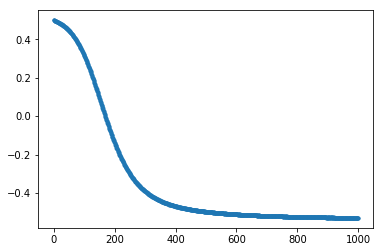

In [8]:
plt.plot(Es,'.')